In [1]:
import os
import uproot
import mplhep
import mpl_scatter_density # adds projection='scatter_density'
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import copy
import numpy as np


Global constants

In [2]:
# global constants
W = 13.5e-3
g1 = 0.1167 #0.108
g2 = 43.56 #40.4
SEsize = 60.17
alpha = 11.43
beta = 1.068
S2thr_upper = 5
S2thr_lower = np.log10(5.5*SEsize)
FVz_upper = 86
FVz_lower = 936.5

Input files

In [3]:
# TODO: rename these so that they're more obviously global variables
#hist_file = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis.root'
#hist_file = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/test.root'
hist_file = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv3_LZAP-5.4.5_v15.root'
#skim_file = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim_SR1-WSv2_LZAP-5.4.5_v11.root'
#skim_file = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim_SR1-WSv3_LZAP-5.4.5_v13.root'
#output_folder = 'test'
output_folder = 'figures_SR1-WSv3_LZAP-5.4.5_v15'
os.makedirs(output_folder,exist_ok=True)

Energy contour functions

In [4]:
def make_energy_contours(energies, recoil_type='ER', logx = False, logy = True):
    
    result = {}
    for energy in energies:
        # E = W * (S1/g1 + S2/g2)
        #W = 13.7e-3
        if logx:
            S1vals = np.linspace(0,5,1000)
            S1valsToUse = np.power(10., S1vals)
        else:
            S1vals = np.linspace(0.1,800,1000)
            S1valsToUse = S1vals
        if recoil_type == 'NR':
            S2vals = (alpha * np.power(energy, beta) - S1valsToUse / g1)*g2
        else:
            S2vals = (energy / W - S1valsToUse/g1) * g2 
            
        if logy:
            S2vals[S2vals<=0] = 1e-9
            S2vals = np.log10(S2vals)
            S2vals[S2vals<2] = -999
        result[energy] = (S1vals, S2vals)
    return result

In [5]:
def plot_energy_contours(ax, Evals, recoil_type = 'ER', logy = True, logx=False, color='gray', lw=0.3, cutoff=200, ypos=2, rotation=-90):
    
    #g1 = 0.108
    #g2 = 40.4
    weight = 0.3
    contours = make_energy_contours(Evals, recoil_type = recoil_type, logy=logy, logx=logx)
    vals = np.array(list(contours.values()))
    xvals = np.transpose(vals[:,0])
    yvals = np.transpose(vals[:,1])
    ax.plot(xvals, yvals, color=color, lw=weight, zorder=5 )

    for energy, line in contours.items():
        xx = line[0]
        yy = line[1]
        xpos = xx[yy<2][2] # choose 2 points to the right to give some whitespace
        if xpos < cutoff:
            if recoil_type == 'NR':
                label = '{} keV$_{{nr}}$'.format(energy)
            else:
                label = '{} keV$_{{ee}}$'.format(energy)
            ax.text(xpos, ypos, label, rotation=rotation, rotation_mode='anchor', transform_rotates_text=True, color=color, fontsize='small')

ER/NR band functions

In [6]:
def retrieve_band(band_file_name):
    #band_file_name = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/modules/SR1ana/python/plotter/Rn220_8kV_logS2_skew_band.txt'
    #band_file_name = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/modules/SR1ana/python/plotter/betaER_8kV_highEnergy_logS2_skew_band.txt'
    #band_file_name = '/global/cfs/cdirs/lz/users/grischbi/CommissioningBands/v3/beta_8kV_highEnergy_logS2_skew_band.txt'
    #band_file_name = 'Rn220_8kV_logS2_skew_band.txt'
    data = []
    with open(band_file_name,'r') as f:
        counter = 0
        for line in f:
            # skip first line 
            if counter == 0:
                counter += 1
                continue
            row = line.rstrip().replace('\t', ' ').replace('[', '').replace(']','').split()
            #print(row)
            vals = [ float(i) for i in row ]
            data.append(vals)
            counter += 1
    data = np.transpose(data)
    res = {}
    res['S1'] = data[0]
    res['logS2mean'] = data[1]
    res['logS2upper'] = data[1] + data[2]
    res['logS2lower'] = data[1] - data[3]
    return res

def retrieve_ER_band():
    band_file_name = '/global/cfs/cdirs/lz/users/grischbi/CommissioningBands/v3/beta_8kV_logS2_skew_band.txt'
    return retrieve_band(band_file_name)

def retrieve_NR_band():
    band_file_name = '/global/cfs/cdirs/lz/users/grischbi/CommissioningBands/v3/flatNR_8kV_logS2_skew_band.txt'
    return retrieve_band(band_file_name)

test = retrieve_ER_band()
#print(test)


In [7]:
def plot_ER_band(ax, logx = False, color='blue', lw=0.5):
    band = retrieve_ER_band()
    if not logx:
        ax.plot(band['S1'], band['logS2mean'], color=color, lw=lw, zorder=20)
        ax.plot(band['S1'], band['logS2upper'], color=color, lw=lw, ls='--', zorder=20)
        ax.plot(band['S1'], band['logS2lower'], color=color, lw=lw, ls='--', zorder=20)
    else:
        ax.plot(np.log10(band['S1']), band['logS2mean'], color=color, lw=lw, zorder=20)
        ax.plot(np.log10(band['S1']), band['logS2upper'], color=color, lw=lw, ls='--', zorder=20)
        ax.plot(np.log10(band['S1']), band['logS2lower'], color=color, lw=lw, ls='--', zorder=20)

def plot_NR_band(ax, logx = False, color='red', lw=0.5):
    band = retrieve_NR_band()
    if not logx:
        ax.plot(band['S1'], band['logS2mean'], color=color, lw=lw, zorder=20)
        ax.plot(band['S1'], band['logS2upper'], color=color, lw=lw, ls='--', zorder=20)
        ax.plot(band['S1'], band['logS2lower'], color=color, lw=lw, ls='--', zorder=20)
    else:
        ax.plot(np.log10(band['S1']), band['logS2mean'], color=color, lw=lw, zorder=20)
        ax.plot(np.log10(band['S1']), band['logS2upper'], color=color, lw=lw, ls='--', zorder=20)
        ax.plot(np.log10(band['S1']), band['logS2lower'], color=color, lw=lw, ls='--', zorder=20)

FV functions

In [8]:
def plot_FV(ax, standoff=4, color='red', lw=0.3):
    
    dt_min = FVz_upper
    dt_max = FVz_lower
    #pol = [71.351, 0.0175366, 4.51307e-5, -8.07743e-9, -2.14047e-10, -3.17783e-13, -1.44533e-16] # active volume wall from Nishat 
    pol = [72.4403, 0.00933984, 5.06325e-5, 1.65361e-7, 2.92605e-10, 2.53539e-13, 8.30075e-17] # updated wall def from Nishat
    dt_vals = np.arange(dt_min, dt_max, 1)
    r_vals = np.zeros(len(dt_vals))
    for i in range(len(pol)):
        r_vals = r_vals + pol[i]*np.power(-dt_vals, i)
    FV_wall_dt = dt_vals
    FV_wall_r = r_vals - standoff # FV is 4 cm from AV wall
    FV_top_r = np.arange(0, FV_wall_r[0], 0.1)
    FV_top_dt = np.zeros(len(FV_top_r)) + dt_min
    FV_bot_r = np.arange(0, FV_wall_r[-1], 0.1)
    FV_bot_dt = np.zeros(len(FV_bot_r)) + dt_max
    ax.plot(FV_top_r**2, -FV_top_dt, color=color, lw=lw, ls='--', zorder=20)
    ax.plot(FV_bot_r**2, -FV_bot_dt, color=color, lw=lw, ls='--', zorder=20)
    ax.plot(FV_wall_r**2, -FV_wall_dt, color=color, lw=lw, ls='--', zorder=20)
    

Hist plotting functions

In [9]:
def plot_cut_set(file, hist, cutlist, cIdx, hIdx, invertedCut = False, folder='figures'):
    
    fig, axs = plt.subplots(2,2, figsize=(12,10))
    axs = axs.flatten()
    
    inversion = copy.deepcopy(cutlist)
    inversion[-1] = '!' + inversion[-1]
    
    if not invertedCut:
        pass_cuts_name = '_'.join(cutlist)
        fail_cuts_name = '_'.join(inversion)
    else:
        pass_cuts_name = '_'.join(inversion)
        fail_cuts_name = '_'.join(cutlist)
    
    # fail_cuts = copy.deepcopy(cutlist)
    # fail_cuts[-1] = '!'+fail_cuts[-1]
    # fail_cuts_name = '_'.join(fail_cuts)
    
    cut_name = pass_cuts_name
    
    h_pass_all = 'h_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx,      cx=pass_cuts_name, hist=hist)
    h_pass_LE =  'h_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+1000, cx=pass_cuts_name+'_LE', hist=hist)
    h_fail_all = 'h_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+50,   cx=fail_cuts_name, hist=hist)
    h_fail_LE =  'h_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+1050, cx=fail_cuts_name+'_LE', hist=hist)
    
    # plotter barfs if try to plot an empty histogram with log colorscale. so check for nonempty before plotting.
    cut_folder = 'CX{cIdx:02d}_{cx}'.format(cIdx=cIdx, cx=cut_name)
    h = file['WS'][cut_folder][h_pass_all].to_hist()
    if np.sum(h.counts()) >= 1:
        h.plot(ax=axs[0], cmin=0.1, norm=colors.LogNorm(), zorder=10)
    h = file['WS'][cut_folder][h_pass_LE].to_hist()
    if np.sum(h.counts()) >= 1:
        h.plot(ax=axs[1], cmin=0.1, zorder=10)
    h = file['WS'][cut_folder][h_fail_all].to_hist()
    if np.sum(h.counts()) >= 1:
        h.plot(ax=axs[2], cmin=0.1, norm=colors.LogNorm(), zorder=10)
    h = file['WS'][cut_folder][h_fail_LE].to_hist()
    if np.sum(h.counts()) >= 1:
        h.plot(ax=axs[3], cmin=0.1, zorder=10)
    
    # set plot titles
    axs[0].set_title(pass_cuts_name)
    axs[1].set_title(pass_cuts_name+'_LE')
    axs[2].set_title(fail_cuts_name)
    axs[3].set_title(fail_cuts_name+'_LE')
    
    for ax in axs:
        ax.set_axisbelow(True)
        ax.grid('both',color='lightgray')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        #ax.set_ylabel('Log$_{10}$(cS2 [phd])')
        #ax.set_xlabel('cS1 [phd]')
    
    # plot energy contours. only for cS2/cS1 plot 
    if hist == 'cS2_cS1':

        LEcontours = [1,3,5,10,20,30,40]
        recoil_type = 'ER'
        plot_energy_contours(axs[1], LEcontours, recoil_type=recoil_type, logx=False, logy=True, cutoff=200)
        plot_energy_contours(axs[3], LEcontours, recoil_type=recoil_type, logx=False, logy=True, cutoff=200)
        plot_ER_band(axs[1], logx=False)
        plot_ER_band(axs[3], logx=False)
        plot_NR_band(axs[1], logx=False)
        plot_NR_band(axs[3], logx=False)
        
        #contours = make_Eee_contours([1,2,10,20,100,200, 1000], g1, g2, logx=True, logy=True)
        HEcontours = [1,3,6,10,30,60, 100,300,600, 1000]
        plot_energy_contours(axs[0], HEcontours, recoil_type=recoil_type, logx=True, logy=True, cutoff=4)
        plot_energy_contours(axs[2], HEcontours, recoil_type=recoil_type, logx=True, logy=True, cutoff=4)
        plot_ER_band(axs[0], logx=True)
        plot_ER_band(axs[2], logx=True)
        plot_NR_band(axs[0], logx=True)
        plot_NR_band(axs[2], logx=True)
        
        for ax in axs:
            ax.plot([0,200],[S2thr_lower, S2thr_lower],ls='--', color='green')
            ax.plot([0,200],[S2thr_upper, S2thr_upper],ls='--', color='green')

        

    if hist == 'dt_r':
        for ax in axs:
            plot_FV(ax)    
    
    fig.subplots_adjust(wspace=0.3, hspace=0.3, left=0.1, right=0.92, top=0.92, bottom=0.1)
    
    file_name = '{folder}/h_{hist}_{cIdx:02d}_{cx}.png'.format(folder=folder, hist=hist, cIdx=cIdx, cx=pass_cuts_name)
    print('Saving {} ...'.format(file_name))
    fig.savefig(file_name, dpi=300, facecolor='white')
    plt.close(fig)


In [10]:
def plot_hist_set(file, cutlist, cIdx, invertedCut = False, folder='figures'):
    
    plot_cut_set(file, 's2_s1', cutlist, cIdx, 0, invertedCut, folder=folder)
    plot_cut_set(file, 'cS2_cS1', cutlist, cIdx, 1, invertedCut, folder=folder)
    plot_cut_set(file, 'dt_r', cutlist, cIdx, 2, invertedCut, folder=folder)
    plot_cut_set(file, 'xy', cutlist, cIdx, 3, invertedCut, folder=folder)
    plot_cut_set(file, 's1_dt', cutlist, cIdx, 4, invertedCut, folder=folder)
    plot_cut_set(file, 's2_dt', cutlist, cIdx, 5, invertedCut, folder=folder)
    plot_cut_set(file, 's1_r', cutlist, cIdx, 6, invertedCut, folder=folder)
    plot_cut_set(file, 's2_r', cutlist, cIdx, 7, invertedCut, folder=folder)

Make the plots!

In [20]:
#file_name = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv1_LZAP-5.4.5_v8.root'
#file_name = 'SR1anaAnalysis_SR1-WS-v1.1_LZAP-5.4.1.root'
file_name = hist_file
    
print('opening {}'.format(file_name))
file = uproot.open(file_name)

#outFolder = 'figures_SR1-WS-v1.8_LZAP-5.4.1'
#outFolder = 'figures_SR1-WSv1_LZAP-5.4.5_v8'
#outFolder = 'figures'
outFolder = output_folder
os.makedirs(outFolder,exist_ok=True)

# For <=v5
# plot_hist_set(file, ['SS'], 1, folder=outFolder) 
# plot_hist_set(file, ['MUONVETO'], 2, folder=outFolder)
# plot_hist_set(file, ['ETV'], 3, folder=outFolder)
# plot_hist_set(file, ['HSX'], 4, folder=outFolder)
# plot_hist_set(file, ['ABOVEANODE'], 5, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['SHORTDT'], 6, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['CATHODE'], 7, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['S2WIDTH'], 8, folder=outFolder)
# plot_hist_set(file, ['STINGER'], 9, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['OTHERECHO'], 10, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['BUFFERS'], 11, folder=outFolder)
# plot_hist_set(file, ['S2UB'], 12, folder=outFolder)
# plot_hist_set(file, ['S2LB'], 13, folder=outFolder)
# plot_hist_set(file, ['ODV'], 14, folder=outFolder)
# plot_hist_set(file, ['SKINV'], 15, folder=outFolder)
# plot_hist_set(file, ['FVz'], 16, folder=outFolder)
# plot_hist_set(file, ['FVr'], 17, folder=outFolder)
# plot_hist_set(file, ['HIGHRATE'], 21, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['WS'], 18, folder=outFolder)
# plot_hist_set(file, ['ODV_WS'], 19, folder=outFolder)
# plot_hist_set(file, ['SKINV_WS'], 20, folder=outFolder)

# for >=v6, <=v11
# plot_hist_set(file, ['SS'], 1, folder=outFolder) 
# plot_hist_set(file, ['MUONVETO'], 2, folder=outFolder)
# plot_hist_set(file, ['ETV'], 3, folder=outFolder)
# plot_hist_set(file, ['HSX'], 4, folder=outFolder)
# plot_hist_set(file, ['FV'], 5, folder=outFolder)
# plot_hist_set(file, ['S2WIDTH'], 6, folder=outFolder)
# plot_hist_set(file, ['STINGER'], 7, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['BUFFERS'], 8, folder=outFolder)
# plot_hist_set(file, ['ODV'], 9, folder=outFolder)
# plot_hist_set(file, ['SKINV'], 10, folder=outFolder)
# plot_hist_set(file, ['OTHERECHO'], 11, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['HIGHRATE'], 12, invertedCut=True, folder=outFolder)


# for >=v12
# plot_hist_set(file, ['SS'], 1, folder=outFolder) 
# plot_hist_set(file, ['MUONVETO'], 2, folder=outFolder)
# plot_hist_set(file, ['ETV'], 3, folder=outFolder)
# plot_hist_set(file, ['HSX'], 4, folder=outFolder)
# plot_hist_set(file, ['FV'], 5, folder=outFolder)
# plot_hist_set(file, ['S2WIDTH'], 6, folder=outFolder)
# plot_hist_set(file, ['STINGER'], 7, folder=outFolder)
# plot_hist_set(file, ['BUFFERS'], 8, folder=outFolder)
# plot_hist_set(file, ['HSC'], 9, folder=outFolder)
# plot_hist_set(file, ['ODV'], 10, folder=outFolder)
# plot_hist_set(file, ['SKINV'], 11, folder=outFolder)
# # plot_hist_set(file, ['OTHERECHO'], 12, invertedCut=True, folder=outFolder)
# plot_hist_set(file, ['EXCESSAREA'], 12, folder=outFolder)
# plot_hist_set(file, ['HIGHRATE'], 13, invertedCut=True, folder=outFolder)
 
# for >=15
plot_hist_set(file, ['SS'], 1, folder=outFolder)
plot_hist_set(file, ['HSX'], 2, folder=outFolder)
plot_hist_set(file, ['MUONVETO'], 3, folder=outFolder)
plot_hist_set(file, ['ETV'], 4, folder=outFolder)
plot_hist_set(file, ['BUFFERS'], 5, folder=outFolder)
plot_hist_set(file, ['SSWINDOW'], 6, folder=outFolder)
plot_hist_set(file, ['XYQUAL'], 7, folder=outFolder)
plot_hist_set(file, ['FV'], 8, folder=outFolder)
plot_hist_set(file, ['S2WIDTH'], 9, folder=outFolder)
plot_hist_set(file, ['STINGER'], 10, folder=outFolder)
plot_hist_set(file, ['HSC'], 11, folder=outFolder)
plot_hist_set(file, ['EXCESSAREA'], 12, folder=outFolder)
plot_hist_set(file, ['HIGHRATE'], 13, folder=outFolder)
plot_hist_set(file, ['ODV'], 14, folder=outFolder)
plot_hist_set(file, ['SKINV'], 15, folder=outFolder)

#plt.show()
plt.close()

opening /global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv3_LZAP-5.4.5_v15.root
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_s2_s1_01_SS.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_cS2_cS1_01_SS.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_dt_r_01_SS.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_xy_01_SS.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_s1_dt_01_SS.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_s2_dt_01_SS.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_s1_r_01_SS.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_s2_r_01_SS.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_s2_s1_02_HSX.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_cS2_cS1_02_HSX.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_dt_r_02_HSX.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_xy_02_HSX.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_s1_dt_02_HSX.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/h_s2_dt_02_HSX.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/

In [11]:
def plot_scatter(ax, cS1, logcS2, color='black', markersize=2, minX=0, maxX=200, minY=2, maxY=5):
    ax.plot(cS1, logcS2, '.', color=color,markersize=markersize)
    # ax.fill_between([0,200],[5,5], [5.5, 5.5], color='none', edgecolor='magenta', hatch='/',ls='--')
    # ax.fill_between([0,200],[np.log10(52*5.5), np.log10(52*5.5)], [0,0], color='none', edgecolor='magenta', hatch='/',ls='--')
    ax.set_xlim(0, 200)
    ax.set_ylim(1, 6)
    ax.set_xlabel('cS1 [phd]')
    ax.set_ylabel('Log$_{10}$(cS2 [phd])')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid('both',color='lightgray')

def plot_scatter_formatted(ax, gr, **kwargs):
    
    # plot the points
    cS1 = gr.values(axis='x')
    logcS2 = gr.values(axis='y')
    plot_scatter(ax, cS1, logcS2, **kwargs)
    
    # plot energy contours
    LE_ER_contours = [1,3,5,10,20,30]
    plot_energy_contours(ax, LE_ER_contours, recoil_type='ER', logx=False, logy=True, cutoff=200, ypos=1.8, rotation=-90, color='gray')
    
    # plot ER, NR bands
    plot_ER_band(ax, logx=False,color='blue')
    plot_NR_band(ax, logx=False,color='red')
    
    # plot S2 thresholds
    ax.plot([0,200],[np.log10(5.5*SEsize), np.log10(5.5*SEsize)],ls='--', color='green')
    ax.plot([0,200],[5,5],ls='--', color='green')

    

In [12]:


def plot_cut_S2S1scatter(file, hist, cutlist, cIdx, hIdx, invertedCut = False, folder='figures'):
    
    fig, axs = plt.subplots(2,2, figsize=(12,10))
    axs = axs.flatten()
    
    # derive the the gr names
    inversion = copy.deepcopy(cutlist)
    inversion[-1] = '!' + inversion[-1]
    
    if not invertedCut:
        pass_cuts_name = '_'.join(cutlist)
        fail_cuts_name = '_'.join(inversion)
    else:
        pass_cuts_name = '_'.join(inversion)
        fail_cuts_name = '_'.join(cutlist)
    
    g_pass_LE = 'g_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+1000, cx=pass_cuts_name+'_LE', hist=hist)
    g_fail_LE = 'g_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+1050, cx=fail_cuts_name+'_LE', hist=hist)
    
    g_pass_LE_ODV = 'g_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+1100, cx=pass_cuts_name+'_LE_!ODV', hist=hist)
    g_pass_LE_SKINV = 'g_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+1200, cx=pass_cuts_name+'_LE_!SKINV', hist=hist)
    #g_fail_LE_ODV = 'g_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+1150, cx=fail_cuts_name+'_LE_!ODV', hist=hist)
    #g_fail_LE_SKINV = 'g_{hIdx:04d}_{cx}_{hist}'.format(hIdx=hIdx+1250, cx=fail_cuts_name+'_LE_!SKINV', hist=hist)

    cutName = 'CX{cIdx:02d}_{cx}'.format(cIdx=cIdx,cx=pass_cuts_name)

    # make the plots
    plot_scatter_formatted(axs[0], file['WS'][cutName][g_pass_LE])
    plot_scatter_formatted(axs[1], file['WS'][cutName][g_fail_LE])

    plot_scatter_formatted(axs[2], file['WS'][cutName][g_pass_LE_ODV], color='orange')
    plot_scatter_formatted(axs[3], file['WS'][cutName][g_pass_LE_SKINV], color='cyan')
    #plot_scatter_formatted(axs[1], file['WS'][cutName][g_fail_LE_ODV], color='orange')
    #plot_scatter_formatted(axs[1], file['WS'][cutName][g_fail_LE_SKINV], color='cyan')

    axs[0].set_title('PASS {}'.format(cutName))
    axs[1].set_title('FAIL {}'.format(cutName))
    axs[2].set_title('PASS {} - OD TAGGED'.format(cutName))
    axs[3].set_title('FAIL {} - SKIN TAGGED'.format(cutName))
    
    
    fig.subplots_adjust(wspace=0.3, hspace=0.3, left=0.1, right=0.92, top=0.92, bottom=0.1)
    
    # save fig
    file_name = '{folder}/g_{hist}_{cIdx:02d}_{cx}.png'.format(folder=folder, hist=hist, cIdx=cIdx, cx=pass_cuts_name)
    print('Saving {} ...'.format(file_name))
    fig.savefig(file_name, dpi=300, facecolor='white')
    
    plt.close(fig)
    

#test
# file = uproot.open('/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/tmp.root')
# plot_cut_S2S1scatter(file, 'cS2_cS1', ['S2WIDTH'], 6, 8, folder='test')

In [13]:
# generate scatter plots per cut
def plot_scatter_set(file, cutlist, cIdx, invertedCut=False, folder='figures'):
    plot_cut_S2S1scatter(file, 'cS2_cS1', cutlist, cIdx, 8, invertedCut, folder=folder)

In [19]:
# generate the scatter plots

#file_name = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/tmp.root'
file_name = hist_file
    
print('opening {}'.format(file_name))
file = uproot.open(file_name)

#outFolder = 'figures_SR1-WS-v1.8_LZAP-5.4.1'
#outFolder = 'figures_SR1-WSv1_LZAP-5.4.5_v8'
outFolder = output_folder
os.makedirs(outFolder,exist_ok=True)

# for >=v9
plot_scatter_set(file, ['S2WIDTH'], 9, folder=outFolder)
plot_scatter_set(file, ['STINGER'], 10, folder=outFolder)
plot_scatter_set(file, ['HSC'], 11, folder=outFolder)
plot_scatter_set(file, ['EXCESSAREA'], 12, folder=outFolder)
plot_scatter_set(file, ['HIGHRATE'], 13, folder=outFolder)
plot_scatter_set(file, ['ODV'], 14, folder=outFolder)
plot_scatter_set(file, ['SKINV'], 15, folder=outFolder)

#plt.show()
plt.close()


opening /global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv3_LZAP-5.4.5_v15.root
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/g_cS2_cS1_09_S2WIDTH.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/g_cS2_cS1_10_STINGER.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/g_cS2_cS1_11_HSC.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/g_cS2_cS1_12_EXCESSAREA.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/g_cS2_cS1_13_HIGHRATE.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/g_cS2_cS1_14_ODV.png ...
Saving figures_SR1-WSv3_LZAP-5.4.5_v15/g_cS2_cS1_15_SKINV.png ...


opening /global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv3_LZAP-5.4.5_v13.root


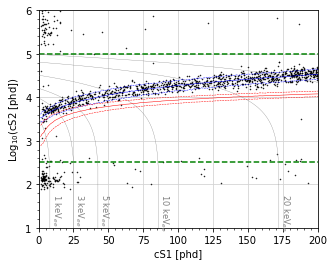

In [26]:
# plot final WS plot from scatter plot

#file_name = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv1_LZAP-5.4.5_v8.root'
file_name = hist_file

print('opening {}'.format(file_name))
file = uproot.open(file_name)

fig, ax= plt.subplots(1,1,figsize=(5,4))
plot_scatter_formatted(ax, file['WS']['g_WS_LE_cS2_cS1'])

#outFolder = 'figures_SR1-WSv1_LZAP-5.4.5_v8'
outFolder = output_folder
os.makedirs(outFolder,exist_ok=True)
fig.savefig('{folder}/g_WS_LE_cS2_cS1.png'.format(folder=outFolder),dpi=300, facecolor='white')



In [17]:
def plot_recoE(ax, recoE, mass=5600, livetime=10, 
               binsize=1, minX=0, maxX=120,minY=0,maxY=50,
               majortickx=10, majorticky=5, minortickx=1, minorticky=1, 
               majortickz=50, minortickz=10,
               color='blue'):
    #binsize = 1
    bins = np.arange(0,200, binsize)
    recoE_binned, bins = np.histogram(recoE, bins)
    #binsize = (bins[1]-bins[0])
    recoE_bincenters = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]

    #recoE_rate = recoE_binned/binsize

    # counting error = sqrt(bin count)
    recoE_yerr = np.sqrt(recoE_binned)

    #plt.step(recoE_bincenters, recoE_binned, where='mid')
    ax.errorbar(recoE_bincenters, recoE_binned, xerr=binsize/2, yerr=recoE_yerr, marker='.', ls='none',color='blue')
    ax.set_xlabel('energy [keV$_{{ee}}$]')
    ax.set_ylabel('cts / bin')
    ax.set_xlim(minX,maxX)
    ax.set_ylim(minY,maxY)
    ax.grid('both')
    ax.xaxis.set_major_locator(MultipleLocator(majortickx))
    ax.xaxis.set_minor_locator(MultipleLocator(minortickx))
    ax.yaxis.set_major_locator(MultipleLocator(majorticky))
    ax.yaxis.set_minor_locator(MultipleLocator(minorticky))

    # duplicate y axis to show normalized rate
    ax2 = ax.twinx()
    # define ax2 tick locations on nice numbers for ax2, but need to be given in units of left ax
    norm = mass*livetime*binsize
    ax2ticks = np.arange(0,500, majortickz) * norm
    print(ax2ticks)

    def tick_function(X):
        y = X/norm
        return ['{:.0f}'.format(i) for i in y]

    ax2.set_yticks(ax2ticks)
    ax2.set_yticklabels(tick_function(ax2ticks))
    ax2.set_ybound(ax.get_ybound())
    ax2.yaxis.set_minor_locator(MultipleLocator(minortickz*norm))
    ax2.set_ylabel('cts / keV / tonne / year', labelpad = 10)

    

opening /global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv3_LZAP-5.4.5_v13.root
[  0.          19.07726027  38.15452055  57.23178082  76.3090411
  95.38630137 114.46356164 133.54082192 152.61808219 171.69534247
 190.77260274 209.84986301 228.92712329 248.00438356 267.08164384
 286.15890411 305.23616438 324.31342466 343.39068493 362.46794521
 381.54520548 400.62246575 419.69972603 438.7769863  457.85424658
 476.93150685 496.00876712 515.0860274  534.16328767 553.24054795
 572.31780822 591.39506849 610.47232877 629.54958904 648.62684932
 667.70410959 686.78136986 705.85863014 724.93589041 744.01315068
 763.09041096 782.16767123 801.24493151 820.32219178 839.39945205
 858.47671233 877.5539726  896.63123288 915.70849315 934.78575342]
[  0.           3.81545205   7.63090411  11.44635616  15.26180822
  19.07726027  22.89271233  26.70816438  30.52361644  34.33906849
  38.15452055  41.9699726   45.78542466  49.60087671  53.41632877
  57.23178082  61.04723288  64.8626

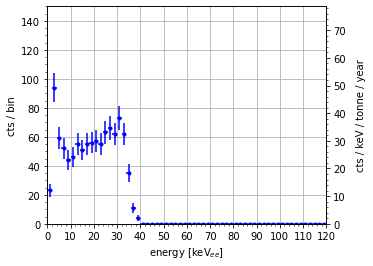

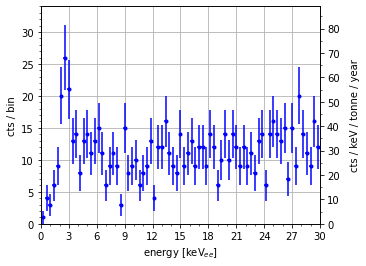

In [65]:
# Plot reconstructed energy

file_name = hist_file

print('opening {}'.format(file_name))
file = uproot.open(file_name)

outFolder = output_folder
os.makedirs(outFolder,exist_ok=True)

g = file['WS']['g_WS_LE_cS2_cS1']
cS1 = g.values(axis='x')
logcS2 = g.values(axis='y')
cS2 = np.power(10, logcS2)

cS1_roi = cS1[np.logical_and(logcS2 > S2thr_lower, logcS2 < S2thr_upper)]
cS2_roi = cS2[np.logical_and(logcS2 > S2thr_lower, logcS2 < S2thr_upper)]

recoE = W*(cS1_roi/g1+cS2_roi/g2)

# exposure
mass = 5.44 # [t]
#livetime = 18.75*0.55/365 #[y] v1
livetime = 64./365 #[y] SR1-WSv1

fig, ax = plt.subplots(1,1,figsize=(5,4))

plot_recoE(ax, recoE, mass=mass, livetime=livetime,
           binsize=2, minX=0, maxX=120, minY=0, maxY=150,
           majortickx=10, majorticky=20, minortickx=2, minorticky=5, 
           majortickz=10,minortickz=2,
           color='blue')

#fig.savefig('{folder}/h_Eee_13_FVr_0-120keV.png'.format(folder=outFolder),dpi=300, facecolor='white',bbox_inches = "tight")

fig, ax = plt.subplots(1,1,figsize=(5,4))

plot_recoE(ax, recoE, mass=mass, livetime=livetime,
           binsize=0.4, minX=0, maxX=30, minY=0, maxY=34,
           majortickx=3, majorticky=5, minortickx=1, minorticky=1, 
           majortickz=10, minortickz=5,
           color='blue')

fig.savefig('{folder}/h_Eee_0-20keV.png'.format(folder=outFolder),dpi=300, facecolor='white',bbox_inches = "tight")

opening /global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv3_LZAP-5.4.5_v13.root
767 events


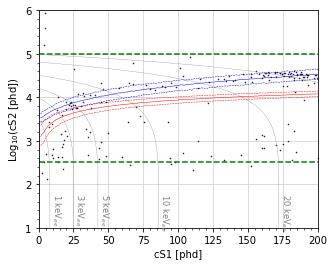

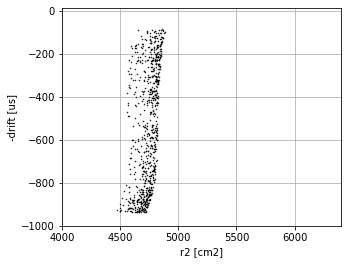

In [61]:
# Plot FV shell volume distribution
# 1. logS2 vs. s1
# 2. (r, drift) distribution - from skim-shell file 

file_name = hist_file

print('opening {}'.format(file_name))
file = uproot.open(file_name)

outFolder = output_folder
os.makedirs(outFolder,exist_ok=True)

g = file['INNERSHELL']['g_2278_!ODV_LE_cS2_cS1']
cS1 = g.values(axis='x')
logcS2 = g.values(axis='y')
cS2 = np.power(10, logcS2)



fig, ax = plt.subplots(1,1,figsize=(5,4))
plot_scatter(ax, cS1, logcS2)
# plot energy contours
LE_ER_contours = [1,3,5,10,20,30]
plot_energy_contours(ax, LE_ER_contours, recoil_type='ER', logx=False, logy=True, cutoff=200, ypos=1.8, rotation=-90, color='gray')

# plot ER, NR bands
plot_ER_band(ax, logx=False,color='blue')
plot_NR_band(ax, logx=False,color='red')

# plot S2 thresholds
ax.plot([0,200],[np.log10(5.5*SEsize), np.log10(5.5*SEsize)],ls='--', color='green')
ax.plot([0,200],[5,5],ls='--', color='green')

fig.savefig('{folder}/g_INNERSHELL_!ODV_LE_cS2_cS1.png'.format(folder=outFolder),dpi=300, facecolor='white')

FVshell_skim_filename = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim-shell_SR1-WSv3_LZAP-5.4.5_v13.root'
FVshellRQs = uproot.open(FVshell_skim_filename)
cS1 = FVshellRQs['Scatters']['ss.correctedS1Area_phd'].array()
cS2 = FVshellRQs['Scatters']['ss.correctedS2Area_phd'].array()
x = FVshellRQs['Scatters']['ss.x_cm'].array()
y = FVshellRQs['Scatters']['ss.y_cm'].array()
drift = FVshellRQs['Scatters']['ss.driftTime_ns'].array()/1000.
logcS2 = np.log10(cS2)
r2 = x*x + y*y
print('{} events'.format(len(cS1)))

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(r2, -drift, '.', color='black',markersize=1)
ax.set_xlabel('r2 [cm2]')
ax.set_ylabel('-drift [us]')
ax.set_xlim(4000,80*80)
ax.set_ylim(-1000,10)
ax.grid('both')

#fig.savefig('{folder}/g_INNERSHELL_LE_dt_r.png'.format(folder=outFolder),dpi=300, facecolor='white')


opening /global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSAnalysis_SR1-WSv3_LZAP-5.4.5_v13.root


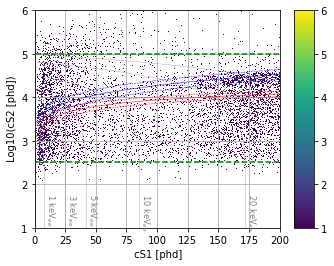

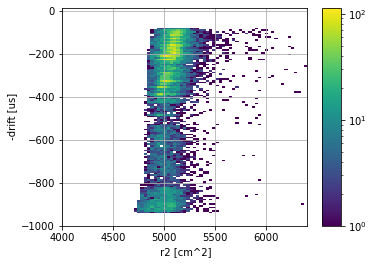

In [54]:

# Plot outer FV shell volume distribution - <2cm from the wall
# 1. logS2 vs. s1
# 2. (r, drift) distribution - from skim-shell file 

file_name = hist_file

print('opening {}'.format(file_name))
file = uproot.open(file_name)

outFolder = output_folder
os.makedirs(outFolder,exist_ok=True)

h = file['OUTERSHELL']['h_3421_ODSKINV_LE_cS2_cS1'].to_hist()



fig, ax = plt.subplots(1,1,figsize=(5,4))
#plot_scatter(ax, cS1, logcS2)
h.plot(ax=ax, cmin=0.1)
ax.set_ylim(1,6)
ax.grid('both')
# plot energy contours
LE_ER_contours = [1,3,5,10,20,30]
plot_energy_contours(ax, LE_ER_contours, recoil_type='ER', logx=False, logy=True, cutoff=200, ypos=1.8, rotation=-90, color='gray')

# plot ER, NR bands
plot_ER_band(ax, logx=False,color='blue')
plot_NR_band(ax, logx=False,color='red')

# plot S2 thresholds
ax.plot([0,200],[np.log10(5.5*SEsize), np.log10(5.5*SEsize)],ls='--', color='green')
ax.plot([0,200],[5,5],ls='--', color='green')

fig.savefig('{folder}/h_OUTERSHELL_LE_cS2_cS1.png'.format(folder=outFolder),dpi=300, facecolor='white')


h = file['OUTERSHELL']['h_3422_ODSKINV_LE_dt_r'].to_hist()
fig, ax = plt.subplots(1,1,figsize=(5,4))
h.plot(ax=ax,cmin=0.1,norm=colors.LogNorm())
ax.grid('both')
ax.set_xlim(4000,80*80)
ax.set_ylim(-1000,10)

fig.savefig('{folder}/h_OUTERSHELL_LE_dt_r.png'.format(folder=outFolder),dpi=300, facecolor='white')

In [14]:
# Function to plot matrix of plots for looking at resistor activity:
# 1. xy 
# 2. logS2 vs. s1 
# 3. r-drift 
# 4. zoom of r-drift to upper corner 

def plot_matrix_resistors(fig, cS1, logcS2, x, y, dt):
  r2 = x*x + y*y


  ax = fig.add_subplot(2,2,1, projection='scatter_density')
  density = ax.scatter_density(x, y, cmap=white_viridis) # norm=colors.LogNorm(vmin=0.1, vmax=300))
  fig.colorbar(density)
  # ax.plot(x,y, '.', markersize=2, color='blue', alpha=0.2)
  ax.set_xlim(-80,80)
  ax.set_ylim(-80,80)
  ax.set_xlabel('x [cm]')
  ax.set_ylabel('y [cm]')

  ax = fig.add_subplot(2,2,2)
  plot_scatter(ax, cS1, logcS2, markersize=1)
  # plot ER, NR bands
  plot_ER_band(ax, logx=False,color='blue')
  plot_NR_band(ax, logx=False,color='red')
  # plot S2 thresholds
  ax.plot([0,200],[np.log10(5.5*SEsize), np.log10(5.5*SEsize)],ls='--', color='green')
  ax.plot([0,200],[5,5],ls='--', color='green')



  ax = fig.add_subplot(2,2,3, projection='scatter_density')
  # ax.plot(r2, -dt, '.', markersize=1, color='black')
  density = ax.scatter_density(r2, -dt, cmap=white_viridis) # norm=colors.LogNorm(vmin=0.1, vmax=300))
  fig.colorbar(density)
  ax.set_xlim(0,80*80)
  ax.set_ylim(-1000,0)
  ax.set_xlabel('r2 [cm2]')
  ax.set_ylabel('-drift [us]')
  #ax.grid('both', color='lightgrey')
  #ax.plot(FV_top_r**2, -FV_top_dt, color=color, lw=lw, ls='--', zorder=20)
  plot_FV(ax, standoff=0, lw=1.5, color='grey')
  ax.plot(np.array([0,80*80]), -np.array([FVz_upper, FVz_upper]), color='purple', lw=2, ls='--')
  ax.plot(np.array([0,80*80]), -np.array([FVz_lower, FVz_lower]), color='purple', lw=2, ls='--')
  plot_FV(ax, standoff=4, lw=2)
  

  ax = fig.add_subplot(2,2,4, projection='scatter_density')
  # density = ax.scatter_density(r2, -dt, cmap=white_viridis) # norm=colors.LogNorm(vmin=0.1, vmax=300))
  # fig.colorbar(density)
  ax.plot(r2, -dt, '.', color='blue', alpha=0.3, markersize=2)
  ax.set_xlim(4000,80*80)
  ax.set_ylim(-350,-50)
  ax.set_xlabel('r2 [cm2]')
  ax.set_ylabel('-drift [us]')
  plot_FV(ax, standoff=0, lw=1.5, color='grey')
  ax.plot(np.array([0,80*80]), -np.array([FVz_upper, FVz_upper]), color='purple', lw=2, ls='--')
  plot_FV(ax, standoff=4, lw=2)

  

16270 events
[39.1, 134, 12.6, 122, 157, 84.8, 198, 162, ... 159, 121, 124, 149, 25.1, 165, 31.3]


/global/homes/a/afan/.conda/envs/lz-plot/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/global/homes/a/afan/.conda/envs/lz-plot/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/global/homes/a/afan/.conda/envs/lz-plot/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/global/homes/a/afan/.conda/envs/lz-plot/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/global/homes/a/afan/.conda/envs/lz-plot/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/global/homes/a/afan

[6784, 7233, 7305, 7362, 7399, 7907, 6782, ... 8075, 8075, 8075, 8075, 8075, 8075]
[65381, 92265, 38756, 17637, 11586, 99483, ... 59107, 83146, 86149, 134669, 138537]


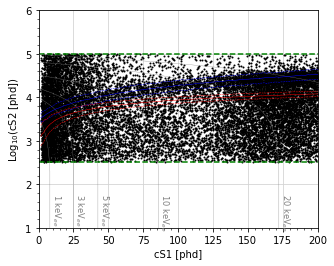

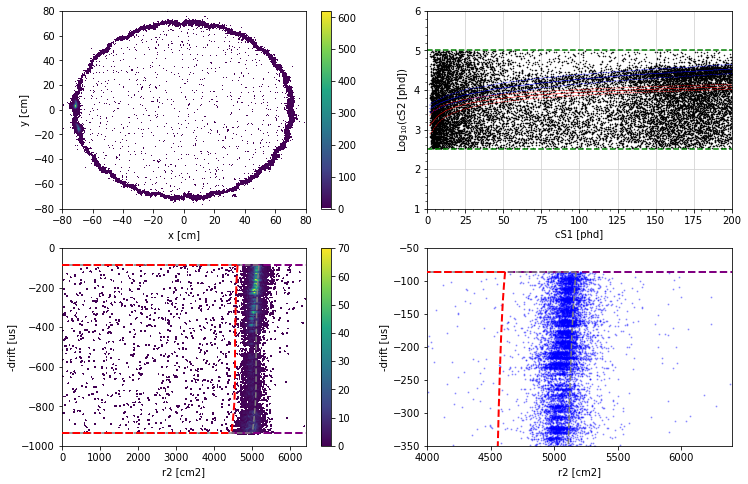

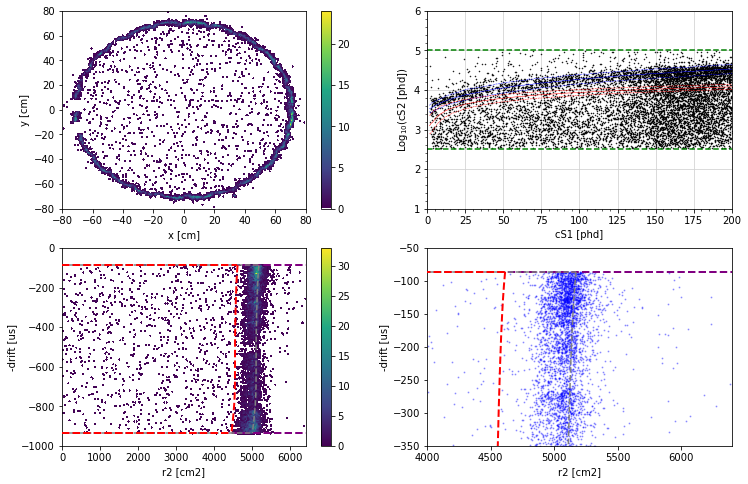

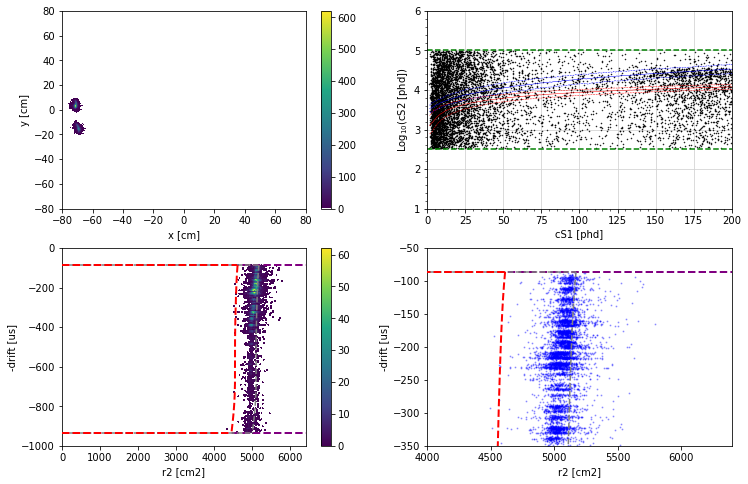

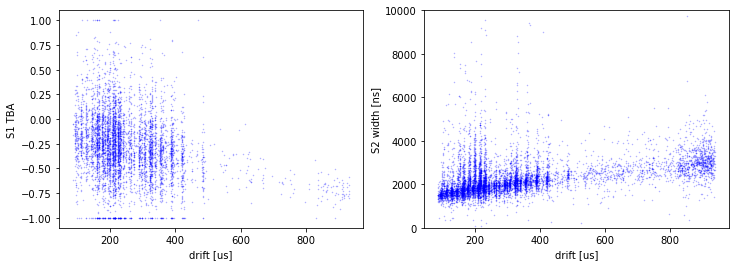

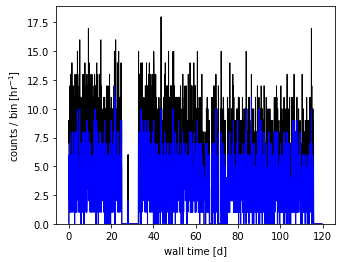

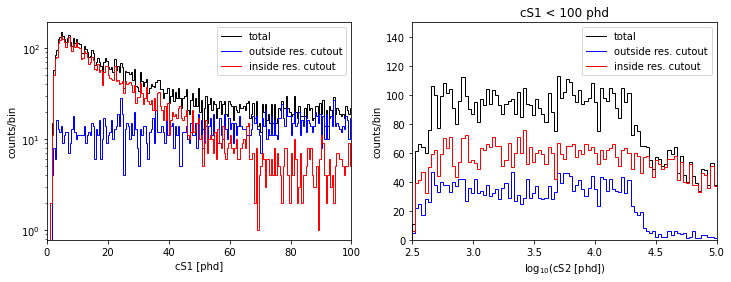

In [41]:
# read skim RQ file to make scatter plots
#skim_filename = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim_SR1-WSv1_LZAP-5.4.5_v6.root'
#skim_filename = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkimB_SR1-WSv3_LZAP-5.4.5-dev-2-ge6c237d-pab_hadesdev_v13.root'
# skim_filename = '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim-outerFVshell_SR1-WSv3_LZAP-5.4.5_v15.root'
# rqs = uproot.open(skim_filename)
# cS1 = rqs['Scatters']['ss.correctedS1Area_phd'].array()
# cS2 = rqs['Scatters']['ss.correctedS2Area_phd'].array()
# dt = rqs['Scatters']['ss.driftTime_ns'].array()
# x = rqs['Scatters']['ss.x_cm'].array()
# y = rqs['Scatters']['ss.y_cm'].array()


# "Viridis-like" colormap with white background
white_viridis = colors.LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=1024)


#----------------------------------------------------------------------------
# load in the data 
file_list = [
    '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim_SR1-WSv3_LZAP-5.4.5_v15.root:Scatters',
    '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim-innerFVshell_SR1-WSv3_LZAP-5.4.5_v15.root:Scatters',
    '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim-outerFVshell_SR1-WSv3_LZAP-5.4.5_v15.root:Scatters'
]
branches = [
    'ss.s1PulseID',
    'ss.s2PulseID',
    'ss.correctedS1Area_phd',
    'ss.correctedS2Area_phd',
    'ss.driftTime_ns',
    'ss.x_cm',
    'ss.y_cm',
    'ss.s1TBA'
]
data = uproot.concatenate(file_list, filter_name=branches)
s1pID = data['ss.s1PulseID']
s2pID = data['ss.s2PulseID']
cS1 = data['ss.correctedS1Area_phd']
cS2 = data['ss.correctedS2Area_phd']
x = data['ss.x_cm']
y = data['ss.y_cm']
dt = data['ss.driftTime_ns']
s1tba = data['ss.s1TBA']

logcS2 = np.log10(cS2)
dt = dt/1.e3
r2 = x*x + y*y 
print('{} events'.format(len(cS1)))
print(cS1)

#outFolder = 'figures_SR1-WS-v2a.1_LZAP-5.4.1'
#outFolder = 'figures'
outFolder = output_folder
os.makedirs(outFolder,exist_ok=True)
save_fig = True

#--------------------------------------------------------------------
# Plot S2/S1 before any cuts 
fig, ax = plt.subplots(1,1,figsize=(5,4))
plot_scatter(ax, cS1, logcS2)

# plot energy contours
LE_ER_contours = [1,3,5,10,20,30]
plot_energy_contours(ax, LE_ER_contours, recoil_type='ER', logx=False, logy=True, cutoff=200, ypos=1.8, rotation=-90, color='gray')

# plot ER, NR bands
plot_ER_band(ax, logx=False,color='blue')
plot_NR_band(ax, logx=False,color='red')

# plot S2 thresholds
ax.plot([0,200],[np.log10(5.5*SEsize), np.log10(5.5*SEsize)],ls='--', color='green')
ax.plot([0,200],[5,5],ls='--', color='green')

#-------------------------------------------------------------------
# plot r,drift and xy before any cuts
#fig, ax = plt.subplots(1,1, figsize=(5,4))
fig = plt.figure(figsize=(12,8))
plot_matrix_resistors(fig, cS1, logcS2, x, y, dt)
if (save_fig):
    fig.savefig('{folder}/h_resistor-study_01-before.png'.format(folder=outFolder),dpi=300, facecolor='white')

#-------------------------------------------------------------------
# define a cut around the resistors.
resistor1cutout = (-70.9, 4.0, 5.4)
resistor2cutout = (-69.1, -14.2, 5.4)
resistor1mask = np.sqrt((x-resistor1cutout[0])*(x-resistor1cutout[0]) + (y-resistor1cutout[1])*(y-resistor1cutout[1])) > resistor1cutout[2]
resistor2mask = np.sqrt((x-resistor2cutout[0])*(x-resistor2cutout[0]) + (y-resistor2cutout[1])*(y-resistor2cutout[1])) > resistor2cutout[2]
resistor_mask = np.logical_and(resistor1mask, resistor2mask)
resistor_select = np.logical_not(resistor_mask)

#------------------------
# plot distributions of events outside the resistors
fig = plt.figure(figsize=(12,8))
plot_matrix_resistors(fig, 
    cS1[resistor_mask],
    logcS2[resistor_mask],
    x[resistor_mask],
    y[resistor_mask],
    dt[resistor_mask] )
if (save_fig):
    fig.savefig('{folder}/h_resistor-study_02-res-pocket-removed.png'.format(folder=outFolder),dpi=300, facecolor='white')



#------------------------
# plot distributions of events near the resistors
fig = plt.figure(figsize=(12,8))
plot_matrix_resistors(fig,
    cS1[resistor_select],
    logcS2[resistor_select],
    x[resistor_select],
    y[resistor_select],
    dt[resistor_select] )
if (save_fig):
    fig.savefig('{folder}/h_resistor-study_03-res-pocket-only.png'.format(folder=outFolder),dpi=300, facecolor='white')


#-----------------------------------------------------------------------
# plot time distribution
file_list = [
    '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim_SR1-WSv3_LZAP-5.4.5_v15.root:Events',
    '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim-innerFVshell_SR1-WSv3_LZAP-5.4.5_v15.root:Events',
    '/global/cfs/cdirs/lz/users/afan/ana/lz/54-SR1/run/SR1WS/SR1WSSkim-outerFVshell_SR1-WSv3_LZAP-5.4.5_v15.root:Events'
]
branches = [
    'eventHeader.runID',
    'eventHeader.eventID',
    'eventHeader.triggerTimeStamp_s',
    'pulsesTPC.topBottomAsymmetry',
    'pulsesTPC.fwhm_ns'
]
data = uproot.concatenate(file_list, filter_name=branches)
runID = data['eventHeader.runID']
eventID = data['eventHeader.eventID']
trgTS = data['eventHeader.triggerTimeStamp_s']
fwhm = data['pulsesTPC.fwhm_ns']

trgTS = trgTS - trgTS[0]
trgTS = trgTS / 3600. / 24.

s2fwhm = [ fwhm[i][int(s2pID[i])] for i in range(len(s2pID)) ]
s2fwhm = np.array(s2fwhm)

#---------------------------------------------------
# plot s2 width and s1 tba vs. drift for resistor events
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()

s1thr = cS1<100
axs[0].plot(dt[np.logical_and(resistor_select, s1thr)], s1tba[np.logical_and(resistor_select, s1thr)],'.',markersize=1,color='blue',alpha=0.3)
axs[0].set_xlabel('drift [us]')
axs[0].set_ylabel('S1 TBA')
axs[0].set_ylim(-1.1,1.1)

axs[1].plot(dt[s1thr], s2fwhm[s1thr], '.', markersize=1, color='blue',alpha=0.3)
axs[1].set_xlabel('drift [us]')
axs[1].set_ylabel('S2 width [ns]')
axs[1].set_ylim(0,10e3)
if (save_fig):
    fig.savefig('{folder}/h_resistor-study_04-s1tba-s2width-res-pocket-only.png'.format(folder=outFolder),dpi=300, facecolor='white')


#------------------------------------------------------
# plot rate vs time 
trgTS_bins = np.arange(0,120,1./24.)
rate_hist_total = np.histogram(trgTS, trgTS_bins)
rate_hist_resistor = np.histogram(trgTS[resistor_mask], trgTS_bins)

fig, ax = plt.subplots(1,1,figsize=(5,4))
mplhep.histplot(rate_hist_total, ax=ax, lw=1, color='black')
mplhep.histplot(rate_hist_resistor, ax=ax, lw=1, color='blue')
ax.set_xlabel('wall time [d]')
ax.set_ylabel('counts / bin [hr$^{-1}$]')
if (save_fig):
    fig.savefig('{folder}/h_resistor-study_05-res-pocket-rate.png'.format(folder=outFolder),dpi=300, facecolor='white')


#---------------------------------------------------------
# plot S1 and S2 spectra 
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()
s1bins = np.arange(0,200,0.5)
s1hist_total = np.histogram(cS1, s1bins)
s1hist_resistor_mask = np.histogram(cS1[resistor_mask], s1bins)
s1hist_resistor_select = np.histogram(cS1[resistor_select], s1bins) 
mplhep.histplot(s1hist_total, ax=axs[0], lw=1, color='black', label='total')
mplhep.histplot(s1hist_resistor_mask, ax=axs[0], lw=1, color='blue', label='outside res. cutout')
mplhep.histplot(s1hist_resistor_select, ax=axs[0], lw=1, color='red', label='inside res. cutout')
axs[0].set_xlim(0,100)
axs[0].set_yscale('log')
axs[0].set_xlabel('cS1 [phd]')
axs[0].set_ylabel('counts/bin')
axs[0].legend(loc='upper right')

s2bins = np.linspace(2.5, 5,100)
s2hist_total = np.histogram(logcS2[cS1<100], s2bins)
s2hist_resistor_mask = np.histogram(logcS2[np.logical_and(resistor_mask, cS1<100)], s2bins)
s2hist_resistor_select = np.histogram(logcS2[np.logical_and(resistor_select, cS1<100)], s2bins) 
mplhep.histplot(s2hist_total, ax=axs[1], lw=1, color='black', label='total')
mplhep.histplot(s2hist_resistor_mask, ax=axs[1], lw=1, color='blue', label='outside res. cutout')
mplhep.histplot(s2hist_resistor_select, ax=axs[1], lw=1, color='red', label='inside res. cutout')
axs[1].set_xlim(2.5,5)
axs[1].set_ylim(0,150)
axs[1].set_xlabel('log$_{10}$(cS2 [phd])')
axs[1].set_ylabel('counts/bin')
axs[1].set_title('cS1 < 100 phd')
axs[1].legend(loc='upper right')
if (save_fig):
    fig.savefig('{folder}/h_resistor-study_06-s1+s2-spectra.png'.format(folder=outFolder),dpi=300, facecolor='white')



#-----------------------------------------------------
# print some events in the resistor chain 
print(runID[np.logical_and(resistor_select, s1thr)])
print(eventID[np.logical_and(resistor_select, s1thr)])

#fig.savefig('{folder}/g_WS_LE_cS2_cS1_dev-2-ge6c237d-pab_hadesdev.png'.format(folder=outFolder),dpi=300, facecolor='white')

# plt.show()